In [134]:
import zipfile
import tensorflow as tf
import pandas as pd
import numpy as np
import emoji
import re
import re
import string
import pickle
import json

# # optional
# import nltk
# nltk.download('stopwords')

Let's get some dirt on our hands. Part of the preprocessing work that must be done is cleaning the data, and preparing it from the model. Here we received a twitter (now called x) dataset comments including messages categorized into three classes: Positive, Negative, and Neutral. Messages that are not relevant to the entity are considered Neutral. The goal is to judge the sentiment of the message regarding the specified entity.

This dataset might be found in [here!](https://huggingface.co/datasets/yogiyulianto/twitter-sentiment-dataset-en).

At first, we clean the data and pre-visualize some rows.

In [135]:
zip_path = './media/datasets/archive.zip'
extract_dir = './media/datasets/csv/'
vocabulary_dir = './media/vocabulary/'
models_dir = './media/models/'

with zipfile.ZipFile(zip_path, 'r') as zip_file:
    zip_file.extractall(extract_dir)

dataframe_train = pd.read_csv(extract_dir+'twitter_training.csv', names=['ID','user','SC','Comment'])
dataframe_test = pd.read_csv(extract_dir+'twitter_validation.csv', names=['ID','user','SC','Comment'])

The data looks as follows:

In [136]:
dataframe_train.iloc[1250:1257]

,ID,user,SC,Comment
1250,2619,Borderlands,Positive,i maed dis bc i love maya (the siren) and im v...
1251,2619,Borderlands,Positive,i do dis bc i am maya (the siren) and im very ...
1252,2619,Borderlands,Positive,i maed is dis bc i love maya ( the siren ) and...
1253,2619,Borderlands,Positive,i maed dis bc i love the (the beautiful) girl ...
1254,2620,Borderlands,Positive,A reimagining of the Keep on the Borderlands. ...
1255,2620,Borderlands,Positive,And he also makes the caves of chaos! This stu...
1256,2620,Borderlands,Positive,"And he's also doing ""The Eagles""! This stuff w..."


So, we can start categorizing the data frames by positive and negative categories for now. In a next proposal, would it be good idea to perform a classification 
including not binary outputs but more aleatory categorization. Additionally, we drop unnecessary columns such as 'ID','user'.

In [137]:
def dropRowValue(dataframe,column,values):
    return dataframe[~dataframe[column].isin(values)]

def sentimentFilter(sentence, category):
    """
    By default the category entered to the sentimentFilter function will be transformed to 1
    """
    sentiment_num_list = []
    for sentiment in sentence:
        if sentiment == category:
            sentiment_num_list.append(1)
        else:
            sentiment_num_list.append(0)
    return sentiment_num_list

# training
filter_dataframe_train = dropRowValue(dataframe_train,'SC',['Neutral','Irrelevant']).drop(['ID','user'], axis=1)
list_x_train = filter_dataframe_train['Comment'].to_list()
list_y_train = filter_dataframe_train['SC'].to_list()
y_train = sentimentFilter(list_y_train,'Positive')

# testing
filter_dataframe_test = dropRowValue(dataframe_test,'SC',['Neutral','Irrelevant']).drop(['ID','user'], axis=1)
list_x_test = filter_dataframe_test['Comment'].to_list()
list_y_test = filter_dataframe_test['SC'].to_list()
y_test = sentimentFilter(list_y_test,'Positive')

I do believe there is a huge importance in the emojis significance in daily dialectic where 59% of consumers aged 18-34 believe companies use too many emojis. 51% of survey respondents said they're likely to engage with a brand's posts if they include emojis. 63% of people think positive emoji usage increases your credibility. 92% of online consumers use emojis every day.

Here I introduce the emoji MASK. Basically, adding a MASK strategy as used in tensors to the emojis over all the training data for improving the accuracy. Doing so, the data will not perceive the unicode text but the emotion text which is given by the emoji translation to text expression. There are another approached to this same problematic such as training the model for identifying the emoji and converting it into an emotion which might be interesting. Nevertheless, the idea is generating the less time complex simple model for solving this issue with the help of python. 

This remembers me once at sentiment analysis competition at UTRGV. Our team decided to go for BERT sentiment analysis strategy which lead to a high computational effort. On the other hand, one of our competitors, whom finally win by 2% more accuracy used statistical approach using hyperparameter tunning using GridSearchCV which was ~70% less computational complex than running a pre-trained LLM model by ~60% less time investment. 

In [138]:
def emojiMask(sentence):
    emoji_mask_sentence = emoji.replace_emoji(sentence,
                        replace=lambda chars,
                        data_dict: chars.encode('ascii', 'namereplace').decode())
    emoji_mask_sentence = re.sub(r"\\N\{(.+?)\}", r"\1", emoji_mask_sentence)
    return emoji_mask_sentence


x_train_emojimask = [emojiMask(str(row)) for row in list_x_train]
x_test_emojimask = [emojiMask(str(row)) for row in list_x_test]

How does the _emojiMask_ function work? Well, consider:

In [139]:
emojiMask("Hello! ☀️ I'm currently enjoying a beautiful day on a tropical island 🏝️ while practicing some yoga 🧘‍♂️ and sipping on a refreshing watermelon juice 🍉🍹. The sound of the waves 🌊 and the warmth of the sun ☀️ make it the perfect day to relax in my swimsuit 👙 and listen to the birds 🦜 singing in the palm trees 🌴. Don't forget your sunglasses 🕶️!")

"Hello! BLACK SUN WITH RAYSVARIATION SELECTOR-16 I'm currently enjoying a beautiful day on a tropical island DESERT ISLANDVARIATION SELECTOR-16 while practicing some yoga PERSON IN LOTUS POSITIONZERO WIDTH JOINERMALE SIGNVARIATION SELECTOR-16 and sipping on a refreshing watermelon juice WATERMELONTROPICAL DRINK. The sound of the waves WATER WAVE and the warmth of the sun BLACK SUN WITH RAYSVARIATION SELECTOR-16 make it the perfect day to relax in my swimsuit BIKINI and listen to the birds PARROT singing in the palm trees PALM TREE. Don't forget your sunglasses DARK SUNGLASSESVARIATION SELECTOR-16!"

In case, there is a stopwords removal just use nltk package together with the following function:

```python
def cleanSentence(sentence, stopwords=True):
    stopwords_vocabulary = nltk.corpus.stopwords.words('english')
    stopwords_pattern = r'\b(?:' + '\s*|'.join(map(re.escape, stopwords_vocabulary)) + r')\b' if stopwords else ''
    lower_sentence = sentence.lower()
    clean_sentence = re.sub(stopwords_pattern + r'|[^\w\s]', '', lower_sentence)
    return clean_sentence
```

In [140]:
def cleanSentence(sentence, stopwords=True):
    stopwords_vocabulary = nltk.corpus.stopwords.words('english')
    stopwords_pattern = r'\b(?:' + '\s*|'.join(map(re.escape, stopwords_vocabulary)) + r')\b' if stopwords else ''
    # clean_sentence = re.sub(stopwords_pattern + r'|[^\w\s]', '', sentence)
    lower_sentence = sentence.lower()
    clean_sentence = re.sub(stopwords_pattern + r'|[^\w\s]', '', lower_sentence)
    return clean_sentence


x_train_clean = [cleanSentence(row) for row in x_train_emojimask]
x_test_clean = [cleanSentence(row) for row in x_test_emojimask]

On Tensorflow, the inputs in the model might be set-up before. Using the pre-loaded models from tensorflow datasets it is quite easier running a model because of the tensors structure is already configure for this purpose. Here, I decided to transform all data into lists, and from lists to tensors.

Additionally, we prepare the datasets for training and testing the final model. The `shuffle` function randomizes the dataset to prevent the model from learning the order of the data. The `batch` function divides the shuffled dataset into batches, improving training speed and efficiency by allowing the model to process multiple samples at once, and the `prefetch` function prefetches data to overlap preprocessing and model execution, reducing training time.

In [141]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

# tensor vector for model
def trainTensorSlice(xlist,ylist):
    x_tensor = tf.constant(xlist)
    y_tensor = tf.constant(ylist)
    dataset_tensor = tf.data.Dataset.from_tensor_slices((x_tensor,y_tensor)) # no batching, the batching will be later on
    return dataset_tensor

train_ds = trainTensorSlice(x_train_clean,y_train)
test_ds = trainTensorSlice(x_test_clean,y_test)


train_dataset = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

I started using the simplest model found on Tensorflow website, specifically the [issue](https://github.com/tensorflow/text/issues/174) were there is a description about the creation of a vocabulary using `tf.lookup.KeyValueTensorInitializer`. Then I realized that if the tokenization needs are simple and the vocabulary is small and static, the approach using `StaticVocabularyTable` can work efficiently. However, there are more complex tokenization needs or dynamic vocabularies, using a higher-level API like `TextVectorization` a text encoder might be more appropriate. These higher-level APIs offer more flexibility and are easier to integrate into TensorFlow models, making them suitable for a wider range of tokenization tasks.

Although, I highly encourage to use the `tf.lookup.KeyValueTensorInitializer` which provides a deep insight about Tensorflow models.

In [142]:
VOCAB_SIZE = 2000
SEQUENCE_LENGTH = 100

encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE,
                                            output_mode='int',
                                            output_sequence_length=SEQUENCE_LENGTH)


encoder.adapt(train_dataset.map(lambda text, label: text))

2024-04-25 12:01:56.067729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [43374]
	 [[{{node Placeholder/_0}}]]
2024-04-25 12:01:56.070372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [43374]
	 [[{{node Placeholder/_1}}]]


### start example

Generate a vocabulary out of the training dataset and de-gerenate it

In [143]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  [b'running win xbox series x thanks billz  achievementland chindocta  realgamerscore gleamiopcfsnreal'
 b'find   twomad played  plays dota 2 makes happy'
 b'n b still ordering shit amazon piece shit blood hands'
 b'19 continuing past endeavors bringing immense publicity bullshit unfinished game  movie company fuckimg integrity making priority game release decent game despite money get game costs vc alone 2 immense embarrassment nba2k ronnie2k 2k httpsconpyltg9whb '
 b'right' b'give game already beautiful man  davidvonderhaar' b''
 b'fix guarding corner please nba2k literally ball guard get open everytime'
 b'borderlands 3 amazing twitchtvnightshade1245_'
 b'want 5 xbox x   get real happy' b'beautiful clean'
 b'congratulations  n2k somehow manage make game worse ever'
 b'proud list hired yes work hard evil ask l10   amazon'
 b'sometimes look overwatch see dead horse surrounded bunch guys suits beating stick xd used adore game seriously dead still playing time time tho  '
 b'aye a

2024-04-25 12:01:58.189120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [43374]
	 [[{{node Placeholder/_0}}]]
2024-04-25 12:01:58.189502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [43374]
	 [[{{node Placeholder/_0}}]]


In [144]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 424,  266,   34,   93,  102,   94,    1,    1,    1,    1,    1,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [ 257,    1,   83,  729,  271,    8,  180,   99,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    

In [145]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'running win xbox series x thanks billz  achievementland chindocta  realgamerscore gleamiopcfsnreal'


NameError: name 'vocab' is not defined

### End example

This introductory model offers simplicity and efficiency through its straightforward architecture and use of a pre-trained `TextVectorization` layer. It benefits from the ability to handle variable-length sequences and capture long-range dependencies, thanks to the `mask_zero=True` and `Bidirectional LSTM` layers. However, its simplicity comes at the cost of limited complexity, which may hinder its performance on tasks requiring nuanced language understanding. Additionally, its relatively large number of parameters could lead to overfitting, particularly on smaller datasets, and its complexity might reduce interpretability and ease of debugging, especially for more complex tokenization and language processing needs.

In this case the database used is quite good for avoiding overfitting. Firstly, we load the vocabulary we will use. 

In [ ]:
# vocabulary_file = open(vocabulary_dir+'vocabulary2T.obj', 'rb')
# loaded_vocabulary = pickle.load(vocabulary_file)
# encoder.set_vocabulary(loaded_vocabulary)

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

If we use the sigmoid activation function as the output layer in our model, converting logits (raw model outputs) to probabilities, the loss function should typically not have `from_logits=True`. This parameter is used with the `BinaryCrossentropy` loss when the model outputs raw logits and the labels are in the range [0, 1]. Since the sigmoid activation already squashes the logits to [0, 1] range, using `from_logits=False` is appropriate, allowing the loss function to interpret the model's output as probabilities directly.

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, 100)              0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 100, 64)           128000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 202,369
Trainable params: 202,369
Non-tr

In [ ]:
history = model.fit(train_dataset, 
                    epochs=10,
                    verbose=2)

Epoch 1/10


2024-04-25 10:03:25.943008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [43374]
	 [[{{node Placeholder/_1}}]]
2024-04-25 10:03:25.943360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [43374]
	 [[{{node Placeholder/_0}}]]
2024-04-25 10:03:29.074800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axi

678/678 - 60s - loss: 0.5434 - accuracy: 0.7283 - 60s/epoch - 89ms/step
Epoch 2/10
678/678 - 49s - loss: 0.3742 - accuracy: 0.8408 - 49s/epoch - 72ms/step
Epoch 3/10
678/678 - 51s - loss: 0.3350 - accuracy: 0.8543 - 51s/epoch - 75ms/step
Epoch 4/10
678/678 - 53s - loss: 0.3131 - accuracy: 0.8644 - 53s/epoch - 78ms/step
Epoch 5/10
678/678 - 51s - loss: 0.2906 - accuracy: 0.8737 - 51s/epoch - 76ms/step
Epoch 6/10
678/678 - 52s - loss: 0.2699 - accuracy: 0.8836 - 52s/epoch - 77ms/step
Epoch 7/10
678/678 - 52s - loss: 0.2521 - accuracy: 0.8903 - 52s/epoch - 76ms/step
Epoch 8/10
678/678 - 56s - loss: 0.2404 - accuracy: 0.8961 - 56s/epoch - 83ms/step
Epoch 9/10
678/678 - 56s - loss: 0.2277 - accuracy: 0.9018 - 56s/epoch - 82ms/step
Epoch 10/10
678/678 - 49s - loss: 0.2184 - accuracy: 0.9047 - 49s/epoch - 72ms/step


Here we save the model. According to the docs it might be saved using the `save` method. Since your model contains a `TextVectorization` layer, which has non-tf.Variable weights, we should use the TensorFlow format _(save_format='tf')_ instead of the HDF5 format (save_format='h5').

In [ ]:
model.save(models_dir+'8T/model8T',save_format='tf')

2024-04-25 00:21:04.910934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-25 00:21:04.920384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-25 00:21:04.927230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

INFO:tensorflow:Assets written to: ./media/models/8T/model8T/assets


INFO:tensorflow:Assets written to: ./media/models/8T/model8T/assets


In [ ]:
load_model = tf.keras.models.load_model(models_dir+'8T/model8T')

2024-04-25 00:31:40.425051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2024-04-25 00:31:40.425209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2024-04-25 00:31:40.425326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [ ]:
loss, accuracy = model.evaluate(test_dataset)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

2024-04-25 10:12:27.341745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [543]
	 [[{{node Placeholder/_1}}]]
2024-04-25 10:12:27.342454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [543]
	 [[{{node Placeholder/_1}}]]


9/9 [==============================] - 3s 22ms/step - loss: 0.1715 - accuracy: 0.9521
Loss: 0.17147158086299896
Accuracy: 0.9521178603172302


dict_keys(['loss', 'accuracy'])


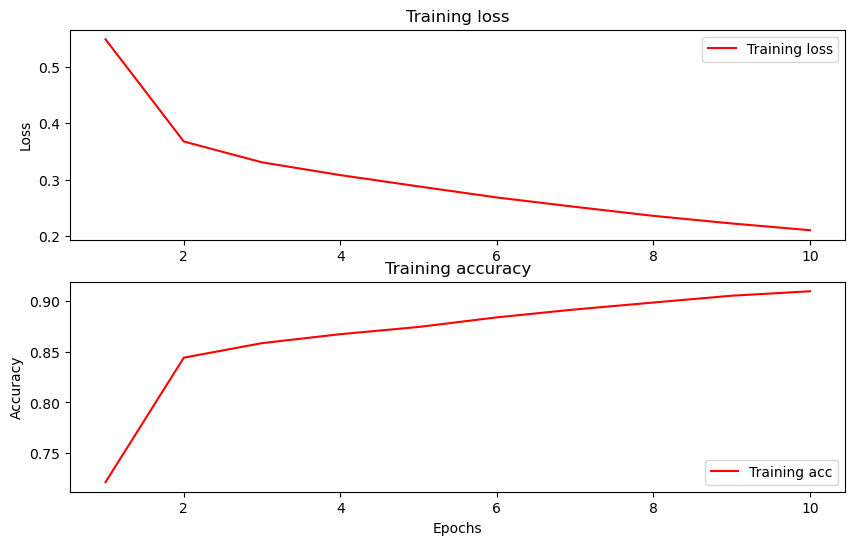

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

One way of analyzing the model performance is running a Monte Carlo simulation. For doing that, there is a `comment.json` file in the datasets directory. This file has 250+ comments with their own categorization (positive or negative), and it will be used for generating the accuracy of the model over time for short sentences with emojis.

In [186]:
with open('./media/datasets/MMcomments/comments.json') as json_file:
    comment_dict = json.load(json_file)


comment_list = comment_dict['comments']
comment_list[0].items()

threshold = 0.5  

prediction_list = []
sentiment_num = []
for _ in range(len(comment_list)):
    for sentence, sentiment in comment_list[_].items():
        sentece_emojiMask = emojiMask(sentence)
        clean_sentence = str(cleanSentence(sentece_emojiMask))
        tf_clean_sentence = tf.constant([clean_sentence])
        prediction = model(tf_clean_sentence)
        binary_prediction = 1 if prediction.numpy()[0][0] > threshold else 0
        prediction_list.append(binary_prediction)
        binary_sentiment = 1 if sentiment == 'positive' else 0
        sentiment_num.append(binary_sentiment)
        

As result I found that the accuracy fluctuates in between ~70% and 78% which directly implies that the model correctly classify 7 out of each 10 comments which indicates a "good" performance of the model. There must be said that the comments used in the `comments.json` file does not necessarily are part from the vocabulary. One possible feature that might increase the model performance is including as much as possible the emojis to the vocabulary, due to the fact that those even thought the type of topic or language spoken are pretty similar. 

In [223]:
np.mean(np.array(prediction_list)==np.array(sentiment_num)) * 100

72.02797202797203